# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

In [5]:
!pip install plotly

### Importar Bibliotecas e Bases de Dados

In [6]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 

#machine learning

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [7]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9,'out': 10, 'nov': 11 , 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    
    nome_mes = arquivo.name[:3]
    
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (87) have mixed types. Specify dtype option on i

In [8]:
display(base_airbnb)

,access,accommodates,amenities,ano,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,...,space,square_feet,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,NaN,4,"{TV,Internet,""Air conditioning"",Kitchen,Doorma...",2018,28,363,58,88,1.0,Real Bed,...,NaN,NaN,RJ,"Rio de Janeiro, RJ, Brazil","Besides the most iconic's view, our apartment ...",NaN,Everything is there. METRO is 5 min walk. Dir...,$823.00,NaN,22250-040
1,The entire apartment is yours. It is a vacatio...,5,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",2018,11,286,29,58,1.0,Real Bed,...,- large balcony which looks out on pedestrian ...,NaN,Rio de Janeiro,"Rio de Janeiro, Rio de Janeiro, Brazil",Please note that special rates apply for New Y...,NaN,Excellent location. Close to all major public ...,NaN,NaN,22020-050
2,"From the International airport, take a regula...",2,"{TV,""Cable TV"",Wifi,""Air conditioning"",""First ...",2018,0,0,0,0,1.0,Real Bed,...,The studio is located at Vinicius de Moraes St...,NaN,Rio de Janeiro,"Rio de Janeiro, Rio de Janeiro, Brazil",My studio is located in the best of Ipanema. ...,NaN,NaN,NaN,NaN,22411-010
3,"internet wi-fi, cable tv, air cond, ceiling fa...",3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",2018,28,363,58,88,1.0,Real Bed,...,This newly renovated studio (last renovations ...,NaN,Rio de Janeiro,"Rio de Janeiro, Rio de Janeiro, Brazil","Our apartment is a little gem, everyone loves ...",NaN,At night we recommend you to take taxis only. ...,NaN,NaN,22060-020
4,"Die Urlauber dürfen das Badezimmer benutzen, d...",3,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",2018,15,345,45,75,1.0,Real Bed,...,This nice and clean 1 bedroom apartment is loc...,NaN,RJ,"Rio de Janeiro, RJ, Brazil",This nice and clean 1 bedroom apartment is loc...,NaN,"Bus, U-Bahn, Taxi und Leihfahrräder in der Nähe.",NaN,NaN,22410-003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",2019,16,351,46,76,1.0,Real Bed,...,NaN,NaN,Rio de Janeiro,"Barra da Tijuca, Rio de Janeiro, Brazil","Em estilo contemporâneo, o Transamerica Prime ...",NaN,NaN,NaN,NaN,22631
34325,Ao alugar o inquilino de temporada desfrutará ...,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",2019,23,83,53,83,2.0,Real Bed,...,O apartamento estará com mobília completa disp...,NaN,Rio de Janeiro,"Jacarepaguá, Rio de Janeiro, Brazil","Confortável apartamento, 2 quartos , sendo 1 s...",NaN,Próximo ao BRT; ônibus gratuito para shoppings...,NaN,NaN,22775-150
34326,Internet wi-fi. Possibilidade para fazer check...,5,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,W...",2019,30,365,60,90,1.0,Real Bed,...,Espaço ideal para até 5 pessoas. Cama de casal...,NaN,Rio de Janeiro,"Copacabana, Rio de Janeiro, Brazil",Apartamento quarto e sala COMPLETO para curtas...,NaN,Estação de Metrô Arco Verde se encontra a 300 ...,NaN,NaN,22011-040
34327,NaN,4,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",2019,17,77,47,77,1.0,Real Bed,...,NaN,NaN,Rio de Janeiro,"Barra da Tijuca, Rio de Janeiro, Brazil",Cobertura alto nivel,NaN,NaN,NaN,NaN,22631-280


- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento
- Além disso, uma análise rápida permite ver que várias colunas são desnecessárias, então vamos excluir algumas colunas
- Colunas com texto e de id serão removidas
- Colunas que vamos excluir
    1. IDs, Links e informações irrelevantes para o modelo
    2. Colunas repetidas ou parecidas com outras(contém a mesma informação, ex: data)
    3. Colunas preenchidas com texto livre (não utilizarei ferramentas de leitura de texto/padrão de texto)
    4. 
- Para isso, vou criar um arquivo em excel        

### Consolidar Base de Dados

In [9]:
base_airbnb.head(1000).to_csv('primeirosregistros.csv')

display(list(base_airbnb.columns))

['access',
 'accommodates',
 'amenities',
 'ano',
 'availability_30',
 'availability_365',
 'availability_60',
 'availability_90',
 'bathrooms',
 'bed_type',
 'bedrooms',
 'beds',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'calendar_last_scraped',
 'calendar_updated',
 'cancellation_policy',
 'city',
 'cleaning_fee',
 'country',
 'country_code',
 'description',
 'experiences_offered',
 'extra_people',
 'first_review',
 'guests_included',
 'has_availability',
 'host_about',
 'host_acceptance_rate',
 'host_has_profile_pic',
 'host_id',
 'host_identity_verified',
 'host_is_superhost',
 'host_listings_count',
 'host_location',
 'host_name',
 'host_neighbourhood',
 'host_picture_url',
 'host_response_rate',
 'host_response_time',
 'host_since',
 'host_thumbnail_url',
 'host_total_listings_count',
 'host_url',
 'host_verifications',
 'house_rules',
 'id',


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [11]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas]
print(list(base_airbnb.columns))
display(base_airbnb)

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,NaN,NaN,f,1.0,-22.946854,-43.182737,Apartment,Entire home/apt,4,1.0,...,9.0,9.0,9.0,9.0,9.0,f,f,strict_14_with_grace_period,2018,4
1,within an hour,100%,t,2.0,-22.965919,-43.178962,Condominium,Entire home/apt,5,1.0,...,9.0,10.0,10.0,9.0,9.0,t,f,strict,2018,4
2,within an hour,100%,f,1.0,-22.985698,-43.201935,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
3,within an hour,100%,f,3.0,-22.977117,-43.190454,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,f,f,strict,2018,4
4,within an hour,100%,t,1.0,-22.983024,-43.214270,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict,2018,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,within an hour,93%,f,0.0,-23.003180,-43.342840,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34325,NaN,NaN,f,0.0,-22.966640,-43.393450,Apartment,Entire home/apt,4,2.0,...,NaN,NaN,NaN,NaN,NaN,f,f,flexible,2019,9
34326,within a few hours,74%,f,32.0,-22.962080,-43.175520,Apartment,Entire home/apt,5,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9
34327,NaN,NaN,f,0.0,-23.003400,-43.341820,Apartment,Entire home/apt,4,1.0,...,NaN,NaN,NaN,NaN,NaN,f,f,strict_14_with_grace_period,2019,9


### Tratar Valores Faltando
- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN

In [12]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())


host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


### - Agora vamos remover as linhas NaN###

In [13]:
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [14]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- Como preço e extra people estão sendo reconhecidos como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna.

In [15]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy = False)
#extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy = False)

### Análise Exploratória e Tratar Outliers
- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

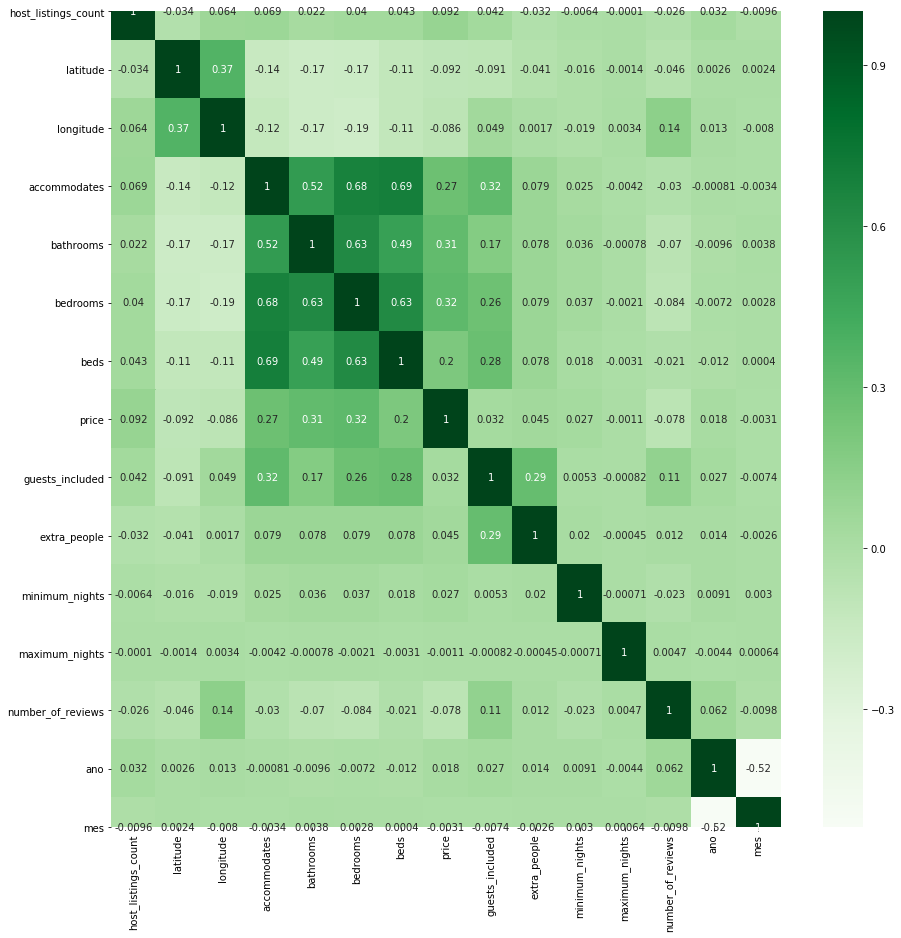

In [16]:
plt.figure(figsize = (15, 15))
sns.heatmap(base_airbnb.corr(), annot = True, cmap= 'Greens')

#print(base_airbnb.corr())

### Definição de Function para análise de outliers
- Vamos definir algumas function para ajudar a analisar as outliers das colunas


In [17]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0] 
    return df, linhas_removidas 

In [18]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) =  plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    

def histograma(coluna):
    plt.figure(figsize = (12, 4))
    sns.distplot(coluna, hist=True)
    
def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))    

### Price

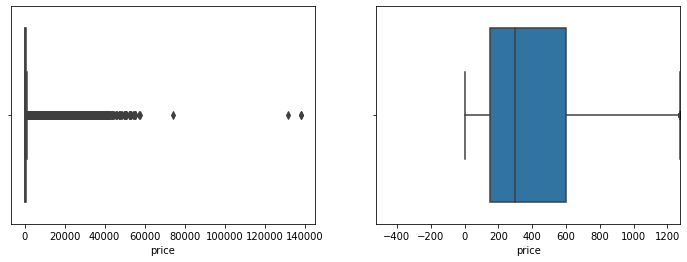

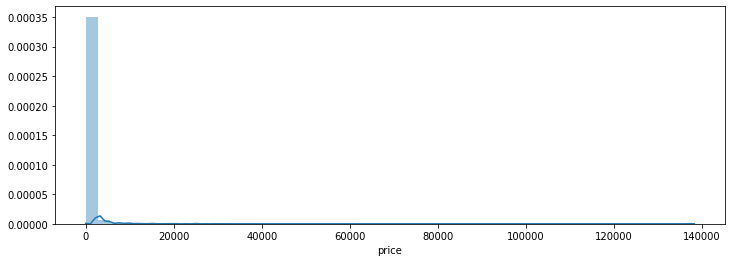

In [19]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])    

In [20]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')

print(f'{linhas_removidas} linhas removidas')

87282 linhas removidas


(810427, 23)


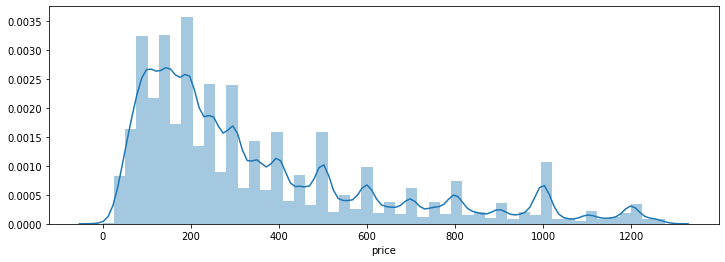

In [21]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

In [22]:
print(limites(base_airbnb['bedrooms']))
base_airbnb['bedrooms'].describe()

(-0.5, 3.5)


count    810427.000000
mean          1.504628
std           0.928901
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          45.000000
Name: bedrooms, dtype: float64

### extra_people

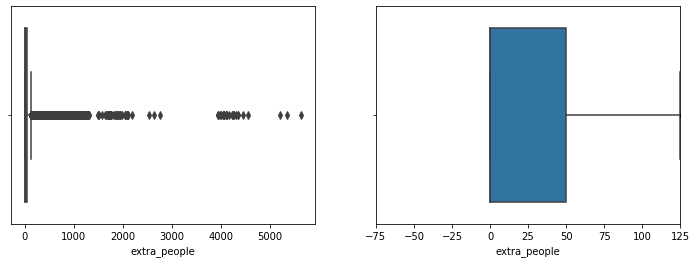

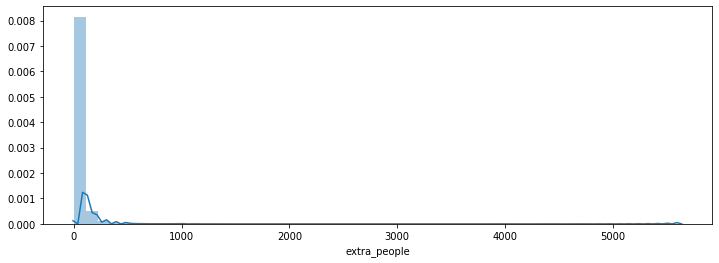

In [23]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])    

### Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas apartamentos/casas de luxo, que não é nosso objetivo principal, então vamos excluir esses outliers

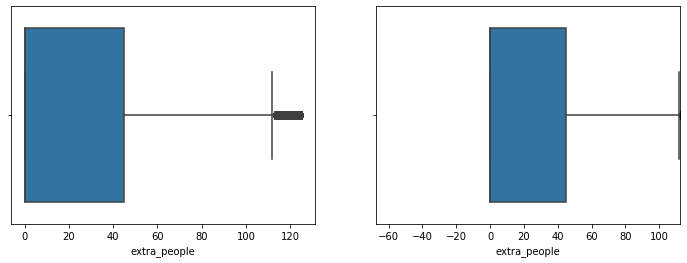

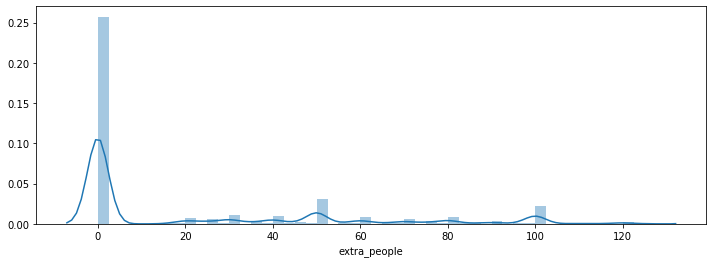

In [24]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])    

### host_listings_count

In [25]:
base_airbnb['host_listings_count'].value_counts()

1.0      391506
2.0      128922
3.0       53462
4.0       31266
5.0       18732
          ...  
488.0         1
485.0         1
161.0         1
329.0         1
114.0         1
Name: host_listings_count, Length: 188, dtype: int64

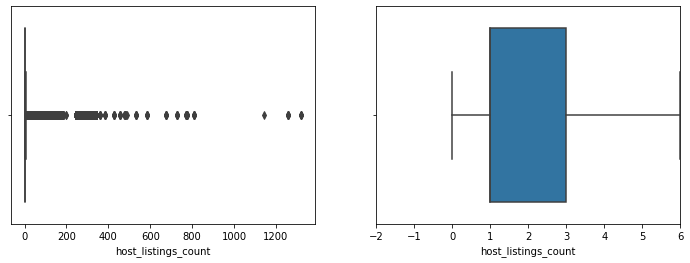

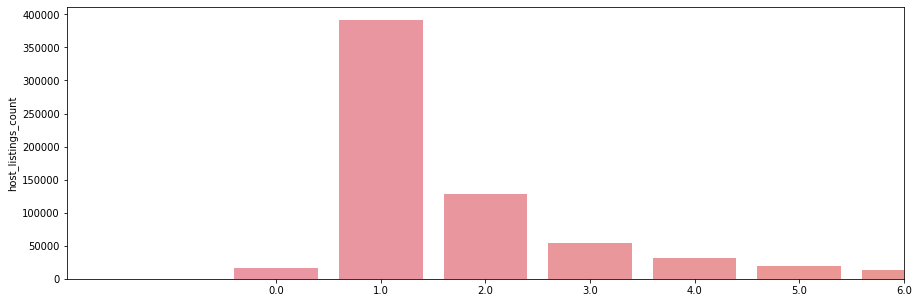

In [26]:

diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])   

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


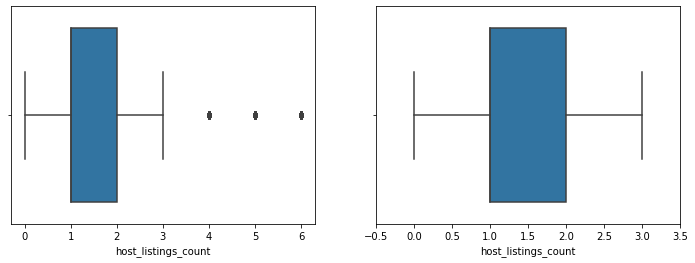

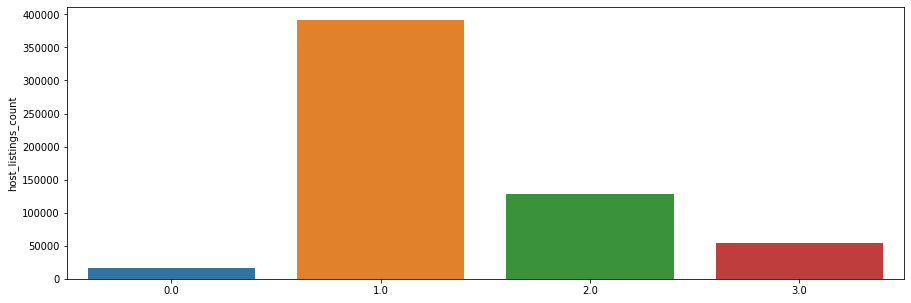

In [28]:

diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])   

### accommodates

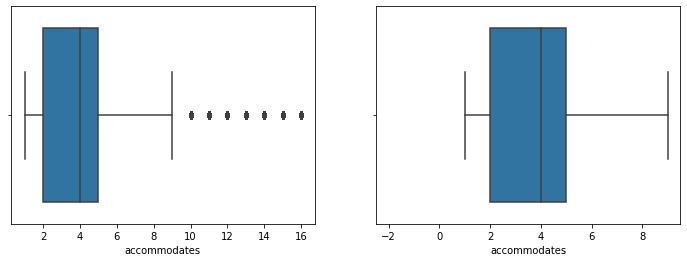

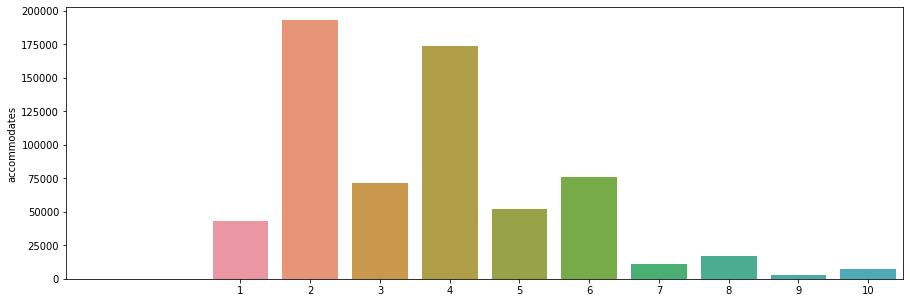

In [29]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Pelo mesmo motivo do "host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

- Caso a gente quisesse incluir apartamentos de alto padrão a gente poderia manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [30]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms

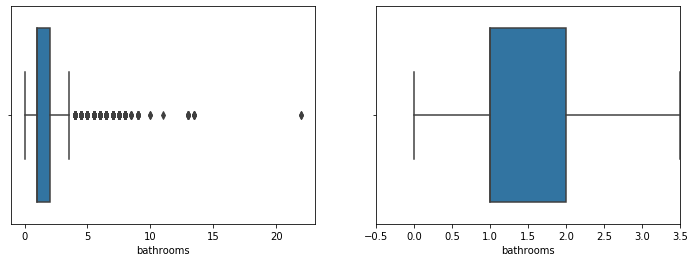

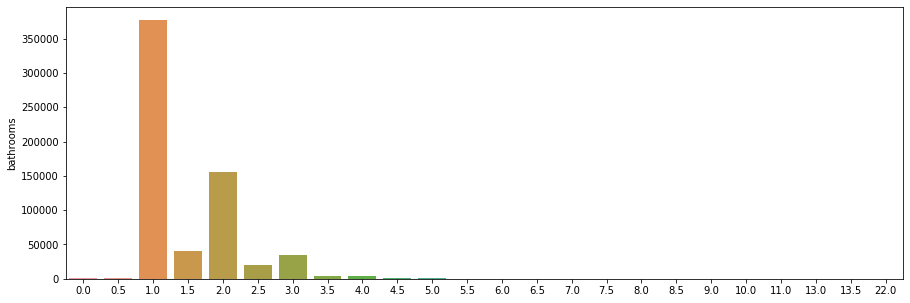

In [31]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [32]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

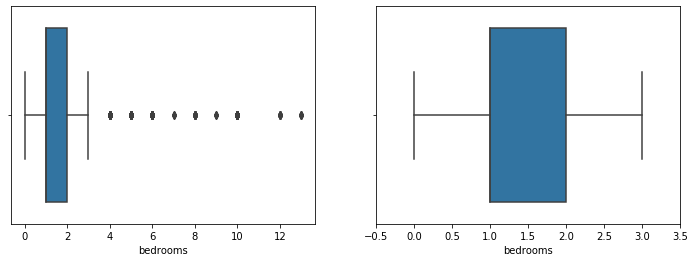

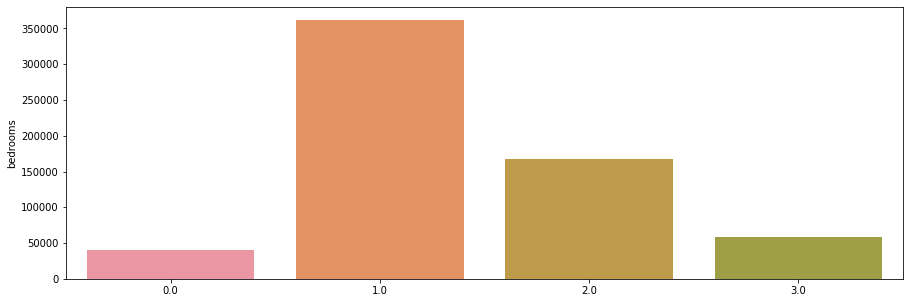

In [33]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [34]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds


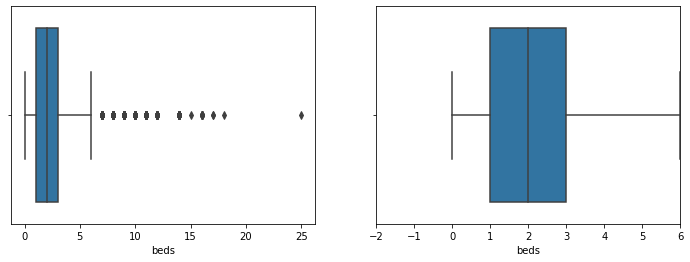

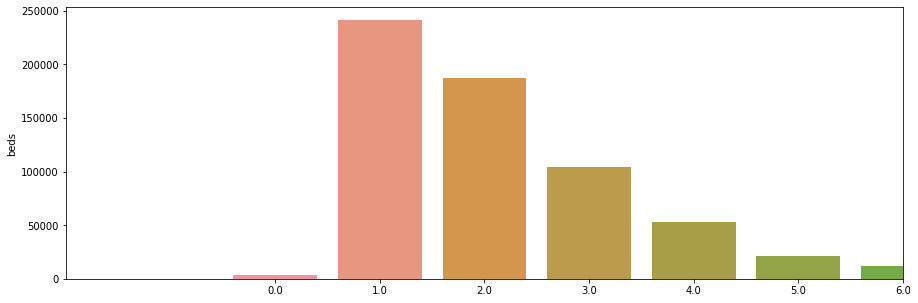

In [35]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [36]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(1.0, 1.0)


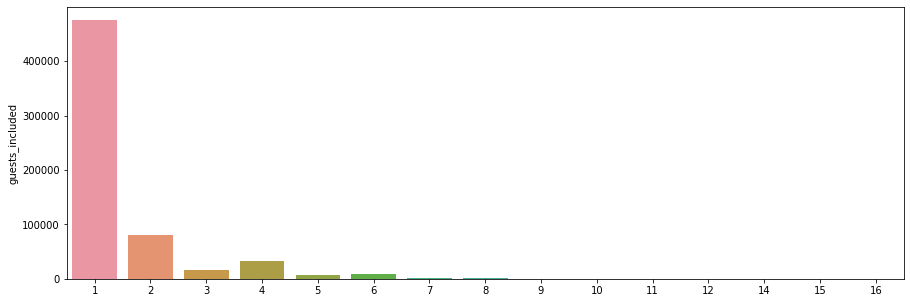

In [37]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

- Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, me parece melhor excluir a coluna da análise

In [38]:

base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights


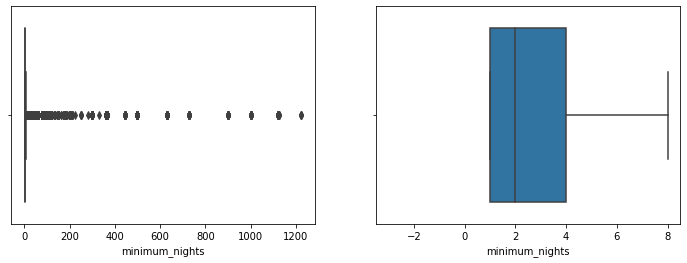

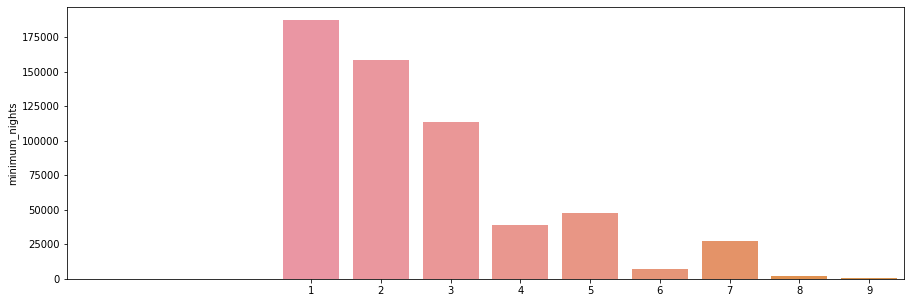

In [39]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [40]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights

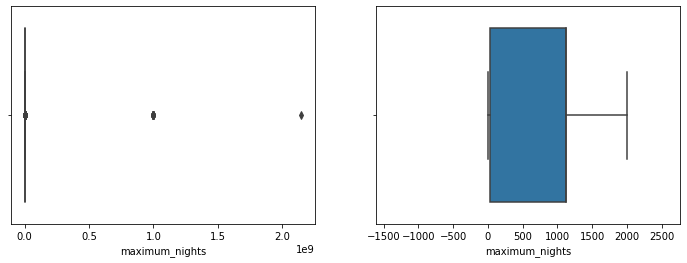

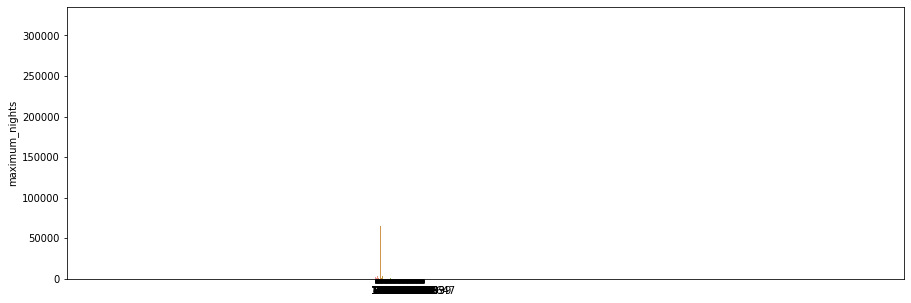

In [41]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluirmos essa coluna da análise

In [42]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews 

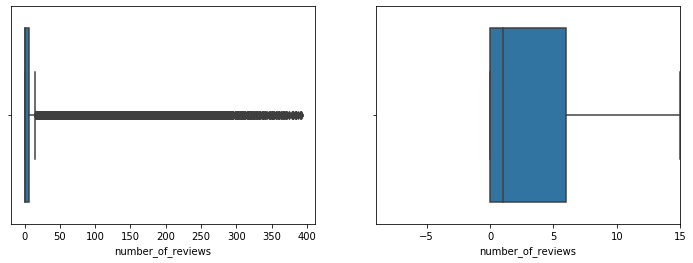

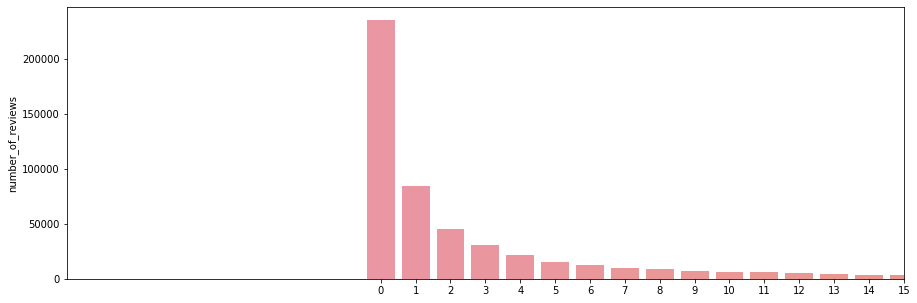

In [43]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Aqui poderíamos tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [44]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

host_is_superhost           
host_listings_count         
accommodates                  
bathrooms                  
bedrooms                   
beds                      
guests_included              
minimum_nights                
maximum_nights               
number_of_reviews          

### Tratamento de Colunas de Valores de Texto



property_type                                                      
room_type                                                     
bed_type                                                             
amenities                   
cancellation_policy                              


- property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

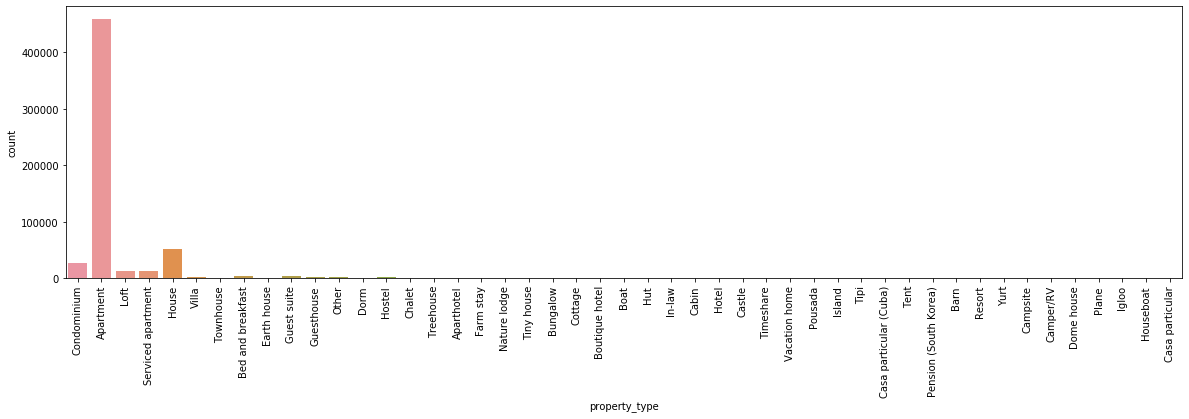

In [45]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

In [46]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
        
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

    
print(base_airbnb['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


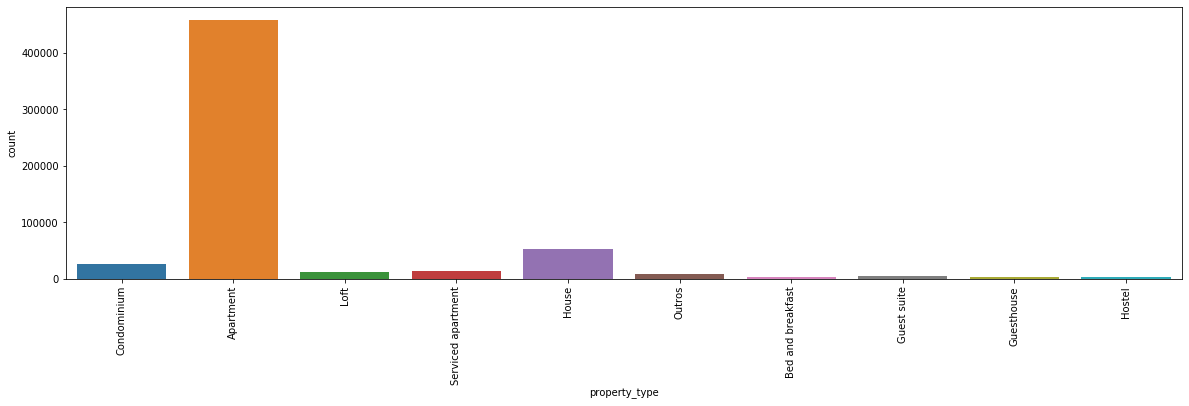

In [47]:
plt.figure(figsize = (20,5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

### room_type  

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


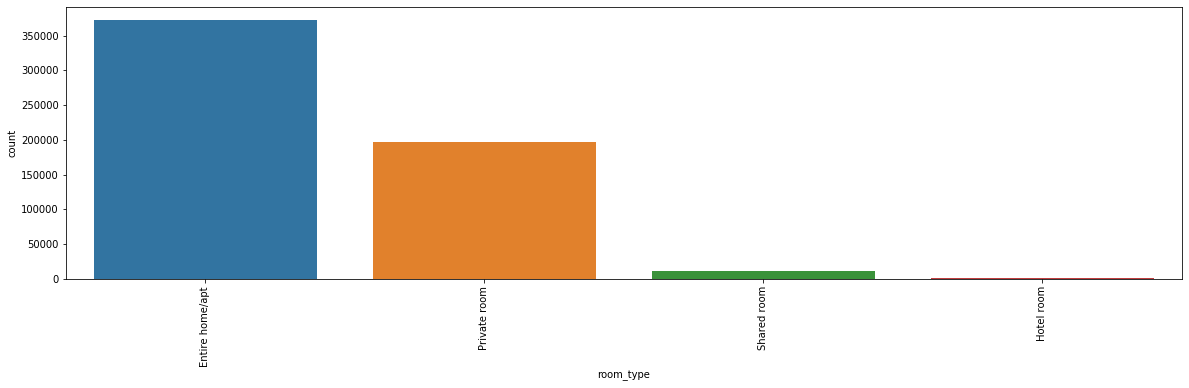

In [48]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

### bed_type 

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


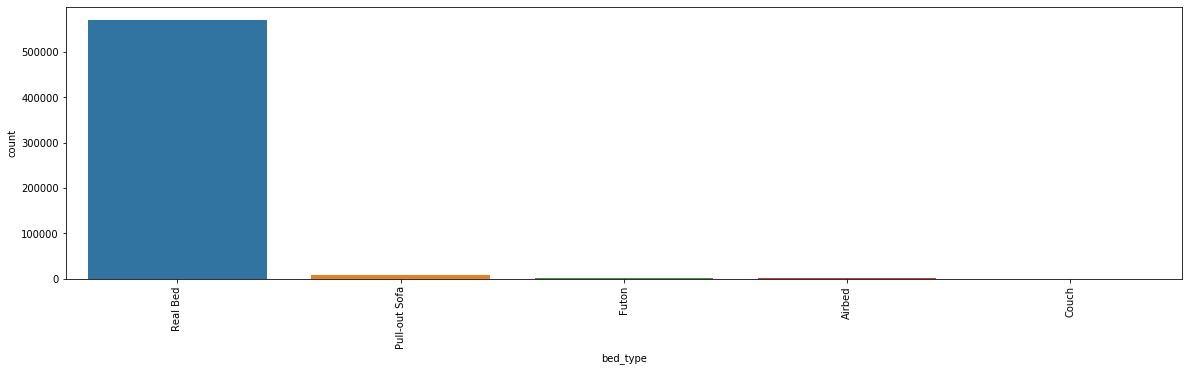

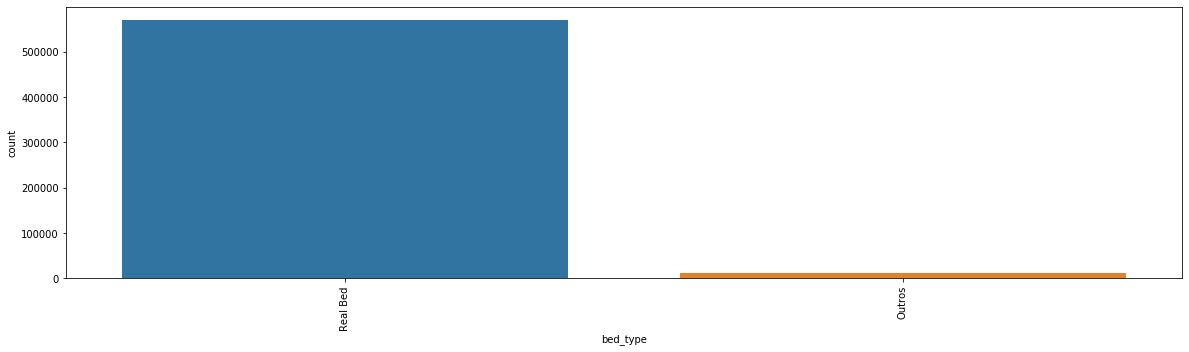

In [49]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)


tabela_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'
    
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

### cancellation_policy 

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


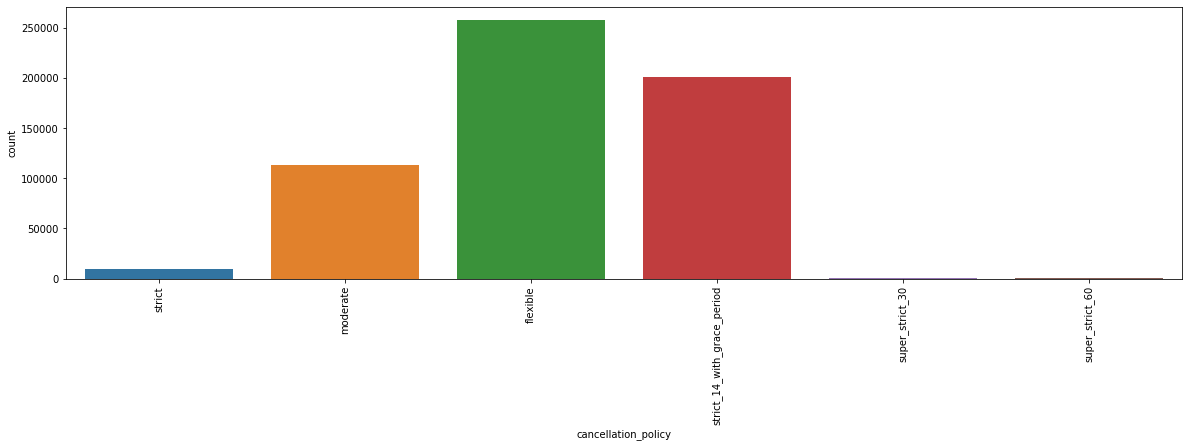

In [50]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


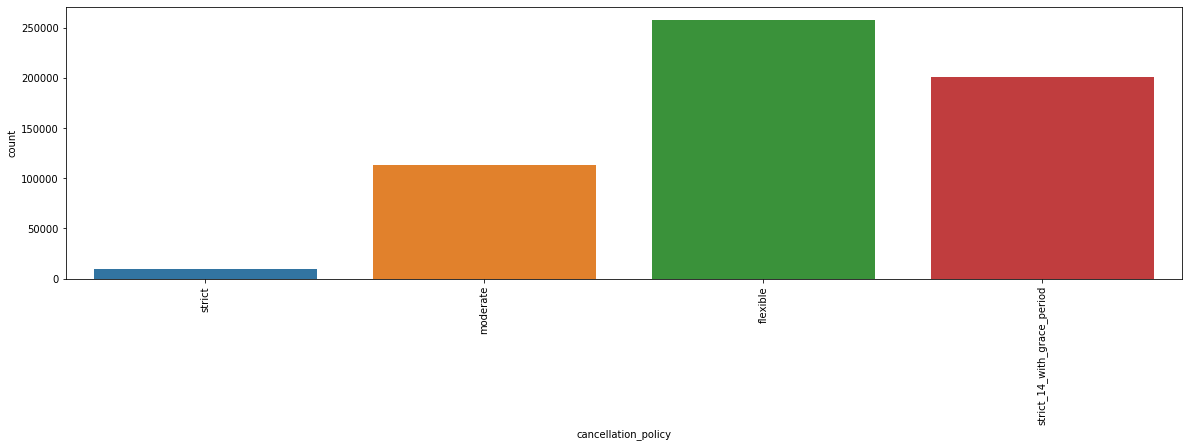

In [51]:
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
        
        
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'
    
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize = (20,5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation = 90)

### amenities

- Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [52]:
print(len(base_airbnb['amenities'].iloc[0].split(',')))

print(base_airbnb['amenities'].iloc[0].split(','))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

print(base_airbnb['n_amenities'])

25
['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']
1        25
3        14
4        16
5        30
6        30
         ..
34323    15
34324    18
34325    12
34327    25
34328    17
Name: n_amenities, Length: 581983, dtype: int64


In [53]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

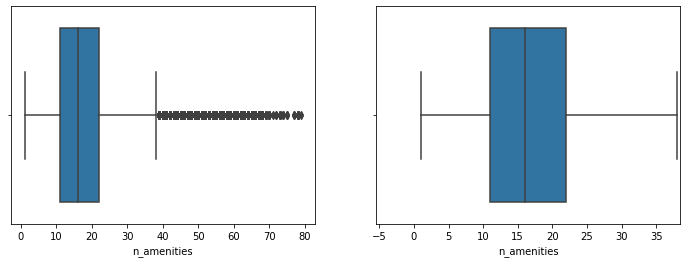

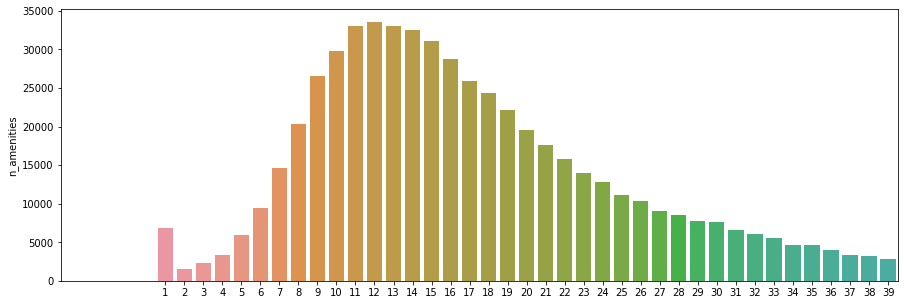

In [54]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [55]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


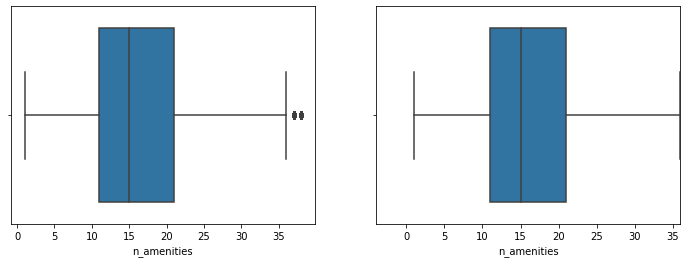

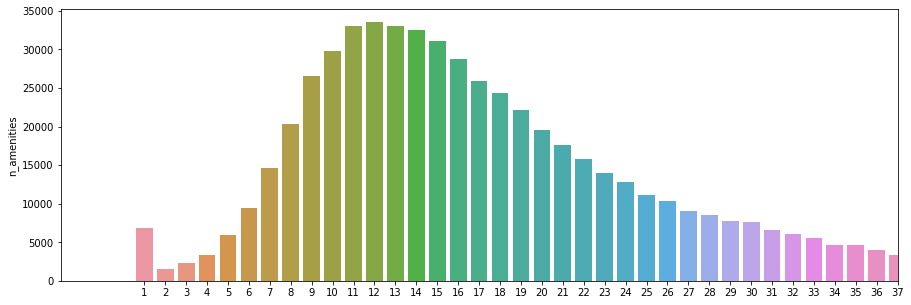

In [56]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

### Visualização de Mapa das Propriedades

In [57]:
import plotly.express as px
import webbrowser
import os

amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

# Cria o gráfico
figura = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                          center=centro_mapa, zoom=10,
                          mapbox_style='carto-darkmatter')

# Salva o código HTML do gráfico em um arquivo local
with open('map.html', 'w', encoding='utf-8') as f:
    f.write(figura.to_html())

# Abre o arquivo HTML em uma nova aba
webbrowser.open('file://' + os.path.realpath('map.html'))

True

### Encoding
Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [58]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[ base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[ base_airbnb_cod[coluna] == 'f', coluna] = 0
print(base_airbnb_cod.iloc[0])

host_is_superhost                         1
host_listings_count                       2
latitude                           -22.9659
longitude                           -43.179
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                                 1
bedrooms                                  2
beds                                      2
bed_type                           Real Bed
price                                   270
extra_people                             51
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object


In [59]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
#transformado os dummies com o pandas, keys (data=dataframe, columns=colunas que vão ser criadas os dummies)

base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)

display(base_airbnb_cod.head())

,host_is_superhost,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,extra_people,...,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Outros,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period
1,1,2.0,-22.965919,-43.178962,5,1.0,2.0,2.0,270.0,51.0,...,1,0,0,0,0,1,0,0,1,0
3,0,3.0,-22.977117,-43.190454,3,1.0,1.0,2.0,161.0,45.0,...,1,0,0,0,0,1,0,0,1,0
4,1,1.0,-22.983024,-43.214270,3,1.0,1.0,2.0,222.0,68.0,...,1,0,0,0,0,1,0,0,1,0
5,1,1.0,-22.988165,-43.193588,3,1.5,1.0,2.0,308.0,86.0,...,1,0,0,0,0,1,0,0,1,0
6,1,1.0,-22.981269,-43.190457,2,1.0,1.0,2.0,219.0,80.0,...,1,0,0,0,0,1,0,0,1,0


### Modelo de Previsão

In [60]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    ###para avaliar o modelo(a IA) vou precisar de 2 infos
    #os valores reais(y_teste) e os valores da previsão(previsao) que a IA fez em cima dos valores reais(y_teste)
    
    # avaliar a previsão
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Escolha dos Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, escolhemos esses 3 modelos. Existem dezenas, ou até centenas de modelos diferentes. A medida com que você for aprendendo mais e mais sobre Ciência de Dados, você vai aprender sempre novos modelos e entendendo aos poucos qual o melhor modelo para usar em cada situação.

Mas na dúvida, esses 3 modelos que usamos aqui são bem bons para muitos problemas de Regressão.

In [61]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = { 
    
            'RandomForest': modelo_rf,
            'LinearRegression': modelo_lr,
            'ExtraTrees': modelo_et,  
    
            }

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)



- Separa os dados em treino e teste + Treino do Modelo

Essa etapa é crucial. As Inteligências Artificiais aprendendo com o que chamamos de treino.

Basicamente o que a gente faz é: a gente separa as informações em treino e teste, ex: 10% da base de dados vai servir para teste e 90% para treino (normalmente treino é maior mesmo)

Aí, damos para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.


Depois que ele aprende, você faz um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste você descobre o melhor modelo

In [62]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo RandomForest:
R²:96.78%
RSME:47.56
Modelo LinearRegression:
R²:32.70%
RSME:217.54


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo ExtraTrees:
R²:97.25%
RSME:43.99


In [63]:
from sklearn.preprocessing import StandardScaler

for nome_modelo, modelo in modelos.items():
    #Criar um objeto StandardScaler
    scaler = StandardScaler()

    #Normalizar os dados de treinamento e teste
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    #Treinar o modelo usando os dados normalizados
    modelo.fit(x_train_scaled, y_train)

    #Realizar predições nos dados de teste normalizados
    previsao = modelo.predict(x_test_scaled)

    #Avaliar o modelo
    print(avaliar_modelo(nome_modelo, y_test, previsao))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo RandomForest:
R²:96.77%
RSME:47.67
Modelo LinearRegression:
R²:32.70%
RSME:217.54


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo ExtraTrees:
R²:97.20%
RSME:44.36


### Análise do Melhor Modelo

In [64]:
for nome_modelo, modelo in modelos.items():
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:-32.76%
RSME:305.55
Modelo LinearRegression:
R²:-119450320857471303844626432.00%
RSME:289819647077038.19


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo ExtraTrees:
R²:-61.65%
RSME:337.15


- Modelo Escolhido como Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²:97.25%%<br>
RSME:43.99

### Ajustes e Melhorias no Melhor Modelo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



,0
latitude,0.102897
longitude,0.100976
n_amenities,0.092172
bedrooms,0.090829
bathrooms,0.085947
extra_people,0.084064
room_type_Entire home/apt,0.076013
accommodates,0.071945
minimum_nights,0.064691
beds,0.052334


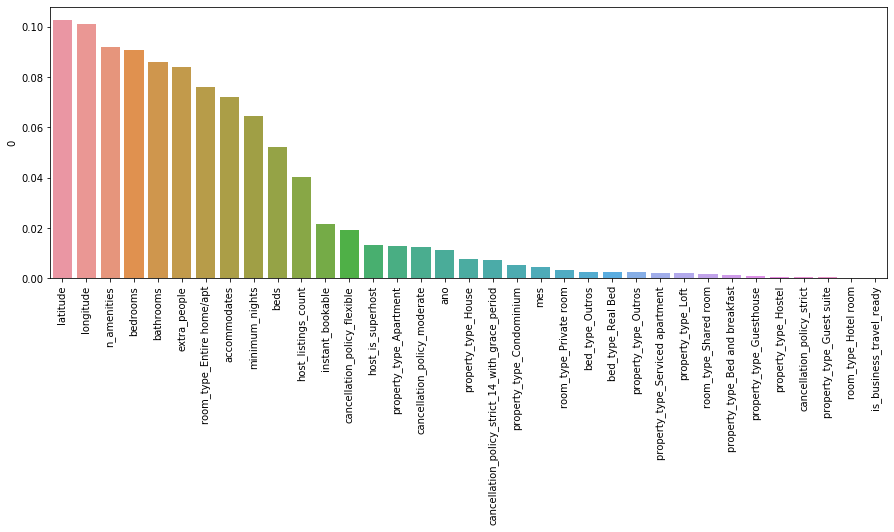

In [65]:
#print(modelo_et.feature_importances_)
#print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [66]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo ExtraTrees:
R²:97.18%
RSME:44.55


In [67]:
base_teste = base_airbnb_cod.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:    
        base_teste = base_teste.drop(coluna, axis=1)
print(base_teste.columns)
y = base_teste['price']
X = base_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room',
       'cancellation_policy_flexible', 'cancellation_policy_moderate',
       'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:230: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



Modelo ExtraTrees:
R²:97.15%
RSME:44.80


In [68]:
print(previsao)

[101.  998.5 249.1 ... 129.8 317.6 120. ]


# Deploy do Projeto


In [69]:
X['price'] = y
X.to_csv('dados.csv')

In [72]:

import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']